# How to extract slices

The SciDataTool python module has been created to **ease the handling of scientific data**, and considerately simplify plot commands. It unifies the extraction of relevant data (e.g. slices), whether they are stored in the time/space or in the frequency domain. The call to Fourier Transform functions is **transparent**, although it still can be parameterized through the use of a dictionary.

This tutorial explains the how to **extract** parts of a field, converted to a specified unit, normalized, and transformed to the Fourier domain.

[Once the data has been stored into `Data` objects](https://github.com/Eomys/SciDataTool/blob/master/SciDataTool/Tutorials/tuto1_Create.ipynb), you will want to plot evolutions, compute postprocessings, etc. You therefore need to **extract** the totality or a part of the data. In the case of an nD field, this corresponds to extracting **slices** of your data. The methods described hereafter are of course also valid for 1D data.

The `DataTime` and `DataFreq` classes have built-in methods to extract slices of the field: the `get_along` methods. One interesting feature is that, no matter whether the data was stored in the **time/space** or the **frequency** domain, the syntax will be **identical**. The `get_along` methods return a **tuple** containing the axes and the field arrays. These methods allow to **intuitively** extract nD slices, as can be seen in the example below:

<IPython.core.display.Javascript object>


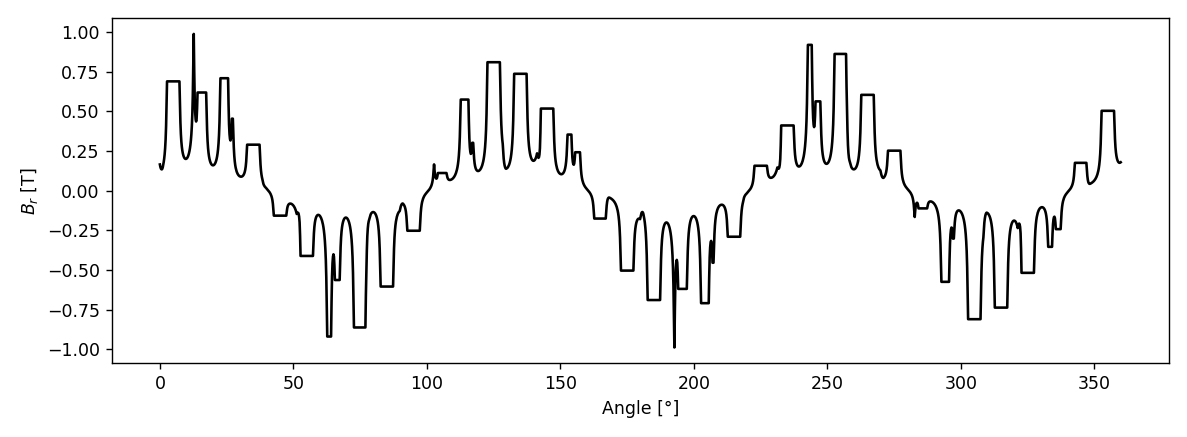

Text(0, 0.5, '$B_r$ [T]')

In [2]:
%matplotlib notebook
# Add SciDataTool to the Python path
import sys
sys.path.append('../..')

# Import useful packages
from os.path import join
from numpy import pi, squeeze, linspace
from pandas import ExcelFile, read_excel
import matplotlib.pyplot as plt

# Import SciDataTool modules
from SciDataTool import Data1D, DataTime
from SciDataTool.Tests import DATA_DIR

# Import scientific data
xls_file = ExcelFile(join(DATA_DIR, "tutorials_data.xlsx"))
time = squeeze(read_excel(xls_file, sheet_name="time", header=None, nrows=1, squeeze=True).to_numpy())
angle = squeeze(read_excel(xls_file, sheet_name="angle", header=None, nrows=1, squeeze=True).to_numpy())
field = read_excel(xls_file, sheet_name="Br", header=None, nrows=2016, squeeze=True).to_numpy()

# Create Data objects
Time = Data1D(name="time", unit="s", values=time)
Angle = Data1D(name="angle", unit="rad", values=angle)
Br = DataTime(
            name="Airgap radial flux density",
            unit="T",
            symbol="B_r",
            axes=[Time, Angle],
            values=field,
        )

#---------------------------------------------------------------
# Extract a slice at t=0.01s
(Xdata1, Ydata1) = Br.get_along("time=0.01", "angle{°}")
#---------------------------------------------------------------

# Plot
fig = plt.figure(tight_layout=True, figsize=(9.5, 3.5))
plt.plot(Xdata1, Ydata1, 'k')
plt.xlabel("Angle [°]")
plt.ylabel(r"$"+Br.symbol+"$ ["+Br.unit+"]")

The **syntax** for the requested axes string is described in the following section. More **advanced functionalities** are presented in the other sections (how to normalize the field or an axis, how to extract a slice in the frequential domain). Finally, for development purposes, the **synopsis** of the `get_along` methods is given in the last section.

## 1. Possible syntaxes for requesting axes
The **syntax** for requesting axes has been designed to be as intuitive as possible. Hereafter is the list of the available syntaxes:
  + `"angle"` for the field over the **complete axis**
  + `"angle=0"` for a slice of the field at a **single value** (possibly interpolated and first occurence if repeated)
  + `"angle[0]"` for a slice of the field at a **single index**. `[-1]` can be used to access the last value.
  + `"angle=[0,3*pi/2]"` for the field over an **interval of values** (possibly interpolated and first occurence if repeated)
  + `"angle[0:200]"` for the field over an **interval given by indices**
  + `"angle=axis_data"` for the field over an **input vector** (using interpolation). This input vector has then to be specified as the argument: `axis_data=[axis_data1, ...]` in the `get_along` method.

The **unit** of the axis can be added to any of the previous strings as `{unit}` (e.g. `"angle[-1]{°}"`).

If nothing is specified regarding an axis from the `axes` list, a slice at its **first value** will be extracted.

The following examples show different syntaxes:

<IPython.core.display.Javascript object>


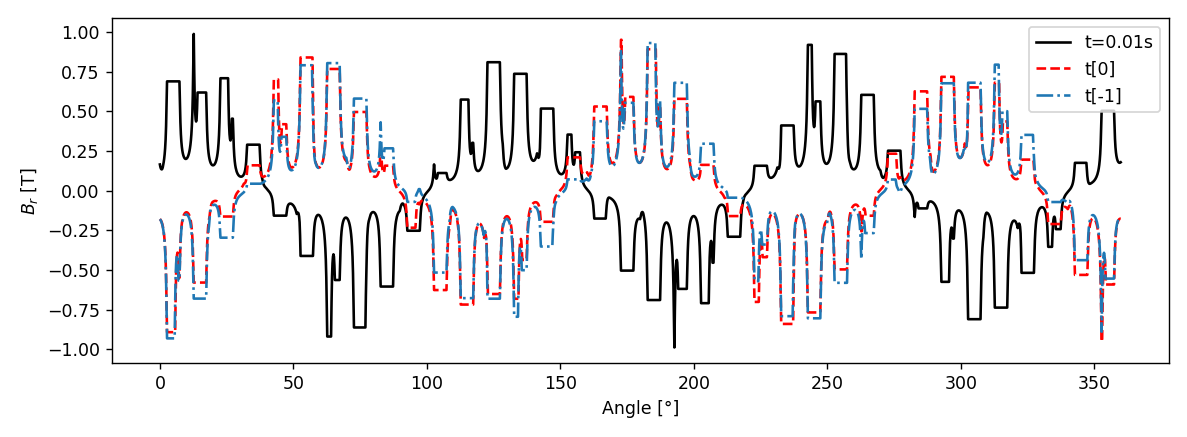

Text(0, 0.5, '$B_r$ [T]')

In [3]:
# Create axis data
angle_data = linspace(0, 360, 1000)

#---------------------------------------------------------------
# Extract slices
(Xdata2, Ydata2) = Br.get_along("angle{°}")
(Xdata3, Ydata3) = Br.get_along("time[-1]", "angle=axis_data{°}", axis_data=[angle_data])
#---------------------------------------------------------------

# Plot
fig = plt.figure(tight_layout=True, figsize=(9.5, 3.5))
plt.plot(Xdata1, Ydata1, 'k', Xdata2, Ydata2, '--r', Xdata3, Ydata3, '-.')
plt.legend(["t=0.01s", "t[0]", "t[-1]"])
plt.xlabel("Angle [°]")
plt.ylabel(r"$"+Br.symbol+"$ ["+Br.unit+"]")

## 2. How to extract slices in the frequential domain

To extract slices in the frequential domain, i.e. to extract **complex Fourier Transform**, **magnitude** or **phase**, use the methods: `get_FT_along`, `get_magnitude_along` or `get_phase_along`. The principle is the same as in the `get_along` methods, with the addition of the Fourier Transform. Note that the name of the Fourier axes must be part of the predefined correspondances:
  + `"time"` &harr; `"freqs"`
  + `"angle"` &harr; `"wavenumber"`

The default method for the Fourier Transform is the numpy fft. See section 6. How to customize Fourier Transform parameters, for other Fourier Transform methods.

The frequencies can be converted to orders (electrical orders, space orders, mechanical orders, etc.) using the `normalizations` dictionary (see example below).

<IPython.core.display.Javascript object>


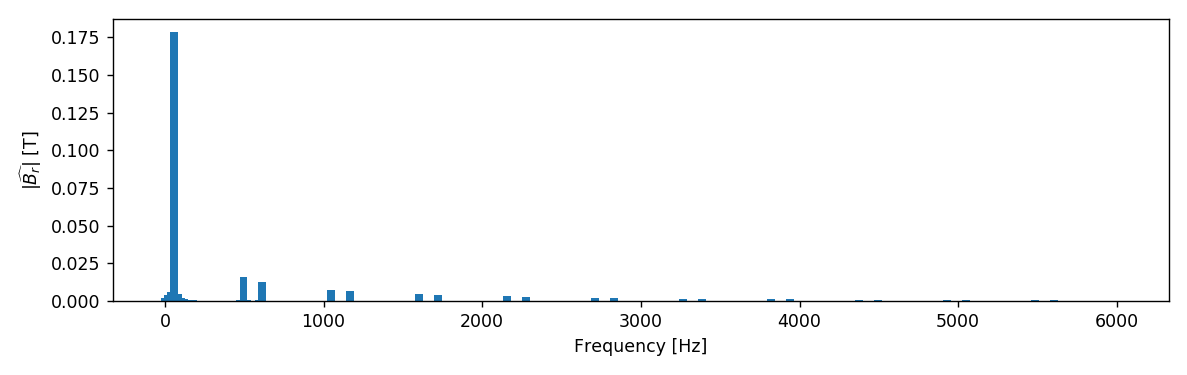

Text(0, 0.5, '$|\\widehat{B_r}|$ [T]')

In [4]:
#---------------------------------------------------------------
# Extract slices
(Xdata4, Ydata4) = Br.get_magnitude_along("freqs=[0,6000]")
#---------------------------------------------------------------

fig = plt.figure(tight_layout=True, figsize=(9.5, 3))
plt.bar(Xdata4, Ydata4, width=50)
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$|\widehat{"+Br.symbol+"}|$ ["+Br.unit+"]")

## 3. How to normalize the field or an axis

To normalize a field or an axis, the `normalizations` attribute can be called. If it was not defined at the `Data` creation step, it is possible to add entries before extracting a slice (see example below).

The normalization of the **field** is activated by the key `is_norm=True`. In this case, the field values will be divided by the reference value stored in `{"ref": ref_value}`. If **dB** or **dBA** are requested in a `get_magnitude_along` method, the reference value will also be the one specified in `normalizations`. If none was provided, the default reference value will be 1.0. It is also possible to add a new unit with its normalization value here.

To normalize an **axis**, for example express frequencies in electrical orders, knowing that one order corresponds to 60Hz, it is also possible to use `normalizations`, and request the input normalization as a unit for the axis. The example below demonstrates this feature:

<IPython.core.display.Javascript object>


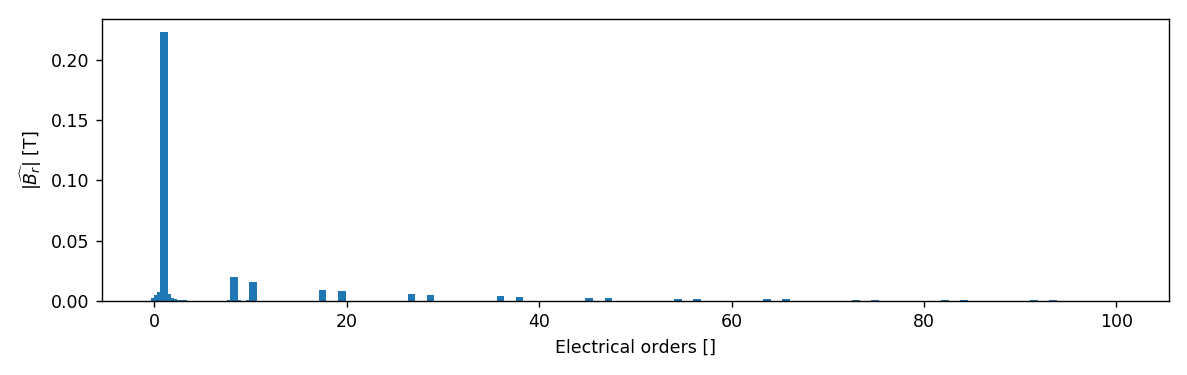

Text(0, 0.5, '$|\\widehat{B_r}|$ [T]')

In [5]:
# Add normalization values
Br.normalizations["ref"] = 0.8
Br.normalizations["elec_order"] = 60

#---------------------------------------------------------------
# Extract slices
(Xdata5, Ydata5) = Br.get_magnitude_along("freqs=[0,100]{elec_order}", is_norm=True)
#---------------------------------------------------------------

# Plot
fig = plt.figure(tight_layout=True, figsize=(9.5, 3))
plt.bar(Xdata5, Ydata5)
plt.xlabel("Electrical orders []")
plt.ylabel(r"$|\widehat{"+Br.symbol+"}|$ ["+Br.unit+"]")

## 4. Synopsis of the `get_along` methods
The `get_along` methods encapsulate several important steps. Hereafter is a summarized description of each of these steps:

- **Extract the requested axes** by calling the `get_axis` methods. These methods will first rebuild the complete axis if a symmetry was used, or compute the time/space axes if the field was stored in the frequency domain, then convert to the requested unit or normalization. If necessary, the axis is then interpolated on the prescribed values (interval or `axis_data`).


- The whole field is then **reconstructed** using the symmetries if the corresponding axis is requested.


- The **slices** of the field are extracted (single index or interval of indices).


- The **Fourier Transform** is performed if necessary (`get_FT_along`, etc. with `DataTime`), or the **inverse Fourier Transform** (`get_along` with `DataFreq`).


- The field is **interpolated** over the specified axis values.


- The field values are **normalized** and **converted** to the requested unit.